### Continuous uniform proposal distribution form phases

The proposal distributions for the phases is uniform[0,180]. While the mcmc chain does eventually converge to the true value, it takes 2 orders of magnitudes longer than if the proposal distribution for the phases are discreteUniform[0, 180]

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import numpy as np
from parmed.topologyobjects import DihedralType
from simtk import unit
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db

Generate toy model that allows continuous phase proposals between 0 and 180

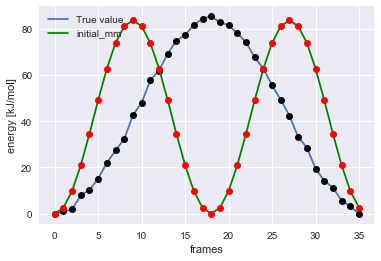

In [4]:
toy = ToyModel(true_value=DihedralType(10, 1, 180, 1, 1), initial_value=DihedralType(10, 2, 180, 1, 1), 
               n_increments=18, sample_phase=True, continuous=True)
plt.plot(toy.synthetic_energy, label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='g', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

In [5]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='continuous_rj.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 427.1 sec

In [7]:
print('true value')
print(toy.true_value)
print('initial value')
print(toy.initial_value)
print(toy.model.pymc_parameters['CG331_CG321_CG321_CG331_1_K'].value)

true value
<DihedralTypes [<DihedralType; phi_k=10.000, per=1, phase=180.000,  scee=1.000, scnb=1.000>]>
initial value
<DihedralTypes [<DihedralType; phi_k=10.000, per=2, phase=180.000,  scee=1.000, scnb=1.000>]>
10.083188335933793


With continuous phase proposals torsionfit gives an OK good fit. 

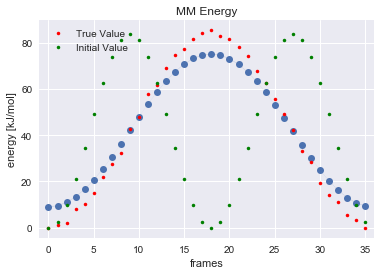

In [8]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.legend()
plt.savefig('energy_fit_cont_rj.pdf')

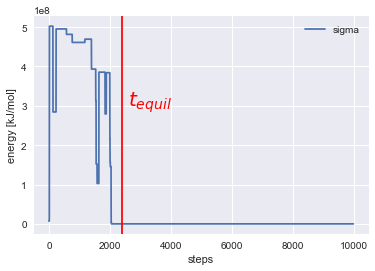

In [15]:
plt.plot(np.exp(sampler.trace('sigma')[9:]), label='sigma')
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.axvline(t, color='red')
plt.text(t+200,300000000,r'$t_{equil}$',rotation=0, color='red', fontsize=20)
plt.savefig('sigma_continous_rj.pdf')

In [10]:
import pymbar.timeseries as ts
[t, g, N_eff] = ts.detectEquilibration(sampler.trace('sigma')[:])
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 2404


This is 2 orders of magnitude larger when compared to discrete proposals (t_quil was 30) !!

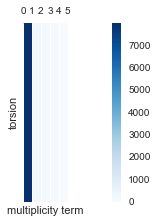

In [11]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, 0)
plt.savefig('multiplicity_continous_rj.pdf')

From the traces of each parameters, you can see how the phase slowly moves to 180 as multiplicity 1 truns on and 2 turns off 

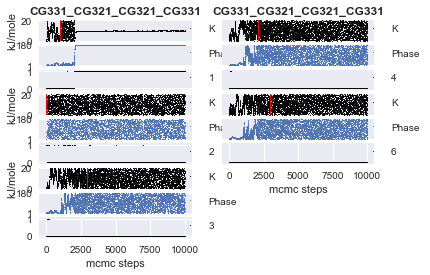

In [13]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, continuous=True, filename='traces_cont_rj.pdf')